In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import baltic as bt
from scipy import stats, optimize
from math import ceil

In [2]:
######  CONFIG  #####

# Pull pre-computed clade frequencies
dataset_name = 'SEAsia'
out_path = '../../../data/titer-model/frequencies/'
frequency_path = '../../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

all_branch_effects_tree = '../../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json'
interserotype_branch_effects_tree = '../../../data/titer-model/interserotype-branch-effects/jsons/dengue_all_tree.json'

uniform_cTiter_clades = [4, 33, 117, 495, 975, 980, 996, 1017, 1020, 1033, 1089, 
                         1386, 1395, 1454, 1588, 1594, 1860, 2027, 2037, 2119, 
                         2167, 2173, 2185, 2230, 2238, 2588]

serotype_clades = [1859,1,1385,974]
genotype_clades = [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638]

date_range = (1970., 2015.)
years_back = 3
years_forward = 5

In [3]:
frequencies = pd.read_csv(frequency_path, index_col=0)
frequencies.rename(columns={i:int(i) for i in frequencies.columns.values}, inplace=True)
frequencies = frequencies.loc[(frequencies.index >= date_range[0]) & (frequencies.index <= date_range[1])]

pivots = frequencies.index.tolist()
n_years = int(pivots[-1]) - int(pivots[0])
ppy = len(pivots)/n_years # pivots per year

pivots_back = years_back*ppy
pivots_forward = years_forward*ppy

informative_pivots = pivots[pivots_back:-1*pivots_forward]
informative_date_range = (informative_pivots[0], informative_pivots[-1])

In [4]:
#####   INPUT   #####
def get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies):
    valid_start = pivots[:-1*pivots_forward] # enough data going forward
    valid_end = pivots[pivots_forward:] 
    delta_t = zip(valid_start, valid_end) 
    
    def ratio(start, end):
        if start < 0.1:
            return np.nan
        else:
            return end / start
    
    f_ratio = { i: [ratio(frequencies[i][start], frequencies[i][end]) for (start, end) in delta_t] for i in frequencies.columns.values}
    f_ratio = pd.DataFrame(f_ratio, index=valid_start)
    return f_ratio.loc[(f_ratio.index >= informative_date_range[0]) & (f_ratio.index <= informative_date_range[-1])]


actual_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies)

In [5]:
all_branch_effects_tree = bt.loadJSON(all_branch_effects_tree, json_translation={'name': 'strain', 'height': 'xvalue'})
interserotype_branch_effects_tree = bt.loadJSON(interserotype_branch_effects_tree, json_translation = {'name': 'strain', 'height': 'xvalue'})

all_branch_effects_clade_lookup = {int(k.traits['clade']) : k for k in all_branch_effects_tree.Objects}
interserotype_branch_effects_clade_lookup = {int(k.traits['clade']):k for k in interserotype_branch_effects_tree.Objects}

for clade, k in all_branch_effects_clade_lookup.items():
    compare = interserotype_branch_effects_clade_lookup[clade]
    assert k.traits['strain'] == compare.traits['strain']
    
    k.traits['interserotype_dTiter'] = compare.traits['dTiter']
    
clade_lookup = all_branch_effects_clade_lookup
titer_tree = all_branch_effects_tree


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [6]:
all_branch_effects_dTiters = {}
interserotype_effects_dTiters = {}

def get_dTiter(clade1, clade2, antigenic_resolution, clade_lookup=clade_lookup):
    key = tuple(sorted([clade1, clade2]))

    if antigenic_resolution == 'serotype':
        dTiters = interserotype_effects_dTiters
        titer_trait = 'interserotype_dTiter'
    else:
        dTiters = all_branch_effects_dTiters
        titer_trait='dTiter'
        
    if key in dTiters:
        return dTiters[key]

    elif clade1 == clade2:
        dTiter = 0.

    else:
        k1, k2 = clade_lookup[clade1], clade_lookup[clade2]
        k1_trace = []
        k2_trace = []
        k = k1 ## Trace from the node 1 to the root (in order)
        while k.index != 'Root':
            k1_trace.append(k)
            k = k.parent
        k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
        while k not in k1_trace:
            k2_trace.append(k)
            k = k.parent
        else:
            mrca = k
        shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
        k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
        total_trace = []
        total_trace += shared_k1_trace
        total_trace += k2_trace
        
        dTiter = sum([k.traits[titer_trait] for k in total_trace])

    dTiters[key] = dTiter
    
    return dTiter

In [7]:
#### Calculate cumulative exposure to genotype i at the START of each season we have data for
def calc_population_exposure(i, gamma, sigma, all_clades, antigenic_resolution, frequencies,
                                 pivots, ppy, pivots_back,informative_pivots, 
                                 max_years_back,informative_date_range):
        
    assert antigenic_resolution in ['clade', 'serotype']
    
    population_exposure = []

    starting_pivots = informative_pivots
    for starting_p in starting_pivots: # each starting season of interest        
        if frequencies[i][starting_p] < 0.1: # if below 10% frequency to start with, don't calculate for this season
            population_exposure.append(np.nan)
            continue

        p_idx = pivots.index(starting_p)
        previous_pivots = pivots[p_idx - pivots_back:p_idx]
        
        cumulative_exposure = 0.
        
        for idx, previous_p in enumerate(previous_pivots, start=1):            
            yrs_back = float(idx)/float(ppy)
            waning = max(gamma*yrs_back + 1, 0.)
            assert 0. <= waning <= 1.
            
            for j in all_clades: # for each genotype
                D_ij = get_dTiter(i,j,antigenic_resolution)
                C_D_ij = 1 + sigma*D_ij # we don't precompute all dTiter values, so check sanity check the sigma value on the fly for each dTiter value
                j_frequency = frequencies[j][previous_p]
                
                exposure = j_frequency * C_D_ij * waning
#                 exposure = j_frequency * D_ij * waning
                cumulative_exposure += exposure
                
        population_exposure.append(cumulative_exposure / float(pivots_back))
    return population_exposure

def calc_all_population_exposure(gamma, sigma, all_clades, antigenic_resolution, frequencies, 
                                 pivots, ppy, pivots_back,informative_pivots, 
                                 max_years_back,informative_date_range):

    
    informative_clades = [i for i in all_clades if frequencies[i].max() >= 0.1]
    
    antigenic_clade_exposure = {i:calc_population_exposure(i, -0.125, -0.15, 
                                                            all_clades, 
                                                            antigenic_resolution, frequencies,
                                                            pivots, ppy, pivots_back,informative_pivots, 
                                                            max_years_back,informative_date_range)
                                for i in informative_clades}
    return pd.DataFrame(antigenic_clade_exposure, index=informative_pivots)

In [65]:
def predict_frequencies(population_exposure, frequencies, years_forward):
    ''' 
    input: population_exposure is a pd.DataFrame(columns=clades, index=pivots, 
                                                values= proportion of the population protected from i)
           frequencies is a pd.DataFrame(columns=clades, index=pivots,
                                         values = relative frequency of clade i at each time point)
    
    output: pd.DataFrame(columns=clades, index=pivots, values=predicted frequency of clade i at each pivot)
    '''
    
    f = 1. - population_exposure # fitness = 1. - proportion of the population protected
    print 'f', f.mean().mean()
    shared_columns = f.columns.values # clades that we've calculated fitness for
    initial_frequencies = frequencies[shared_columns]
    print 'init', initial_frequencies.mean().mean()
    predicted_delta_frequencies = f.applymap(lambda x: np.log(x+years_forward)) # df = e^(Pi + dt), applied element-wise
    print 'delta', predicted_delta_frequencies.mean().mean()
    raw_predicted_frequencies = initial_frequencies.add(predicted_delta_frequencies, fill_value=0.) # f = f0 + df
    print 'raw', raw_predicted_frequencies.mean().mean()
    sum_predicted_frequencies = raw_predicted_frequencies.sum(axis=1) # sum of all predicted frequencies at each time point
    print 'sum', sum_predicted_frequencies.mean()
    
    predicted_frequencies = raw_predicted_frequencies.divide(sum_predicted_frequencies, axis='index') # norm each row to sum to 1
    print 'predicted', predicted_frequencies.mean().mean()
    return predicted_frequencies

In [14]:
geno_exposure = calc_all_population_exposure(gamma=-0.125, sigma=-0.15, 
                                             all_clades=genotype_clades, 
                                             antigenic_resolution='clade', 
                                             frequencies=frequencies,
                                             pivots=pivots, ppy=ppy, 
                                             pivots_back=pivots_back,
                                             informative_pivots=informative_pivots, 
                                             max_years_back=years_back,
                                             informative_date_range=informative_date_range)

sero_exposure = calc_all_population_exposure(gamma=-0.125, sigma=-0.15, 
                                             all_clades=genotype_clades, 
                                             antigenic_resolution='serotype', 
                                             frequencies=frequencies,
                                             pivots=pivots, ppy=ppy, 
                                             pivots_back=pivots_back,
                                             informative_pivots=informative_pivots, 
                                             max_years_back=years_back,
                                             informative_date_range=informative_date_range)

In [66]:
genoAntRes_predicted_frequencies = predict_frequencies(geno_exposure, frequencies, years_forward)
genoAntRes_predicted_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, 
                                                           informative_date_range, genoAntRes_predicted_frequencies)

seroAntRes_predicted_frequencies = predict_frequencies(sero_exposure, frequencies, years_forward)
seroAntRes_predicted_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, 
                                                       informative_date_range, seroAntRes_predicted_frequencies)

shared_columns = genoAntRes_predicted_frequency_ratio.columns.values
actual_frequency_ratio = actual_frequency_ratio[shared_columns]

f 0.526779346992
init 0.0572430939227
delta 1.70940323454
raw 0.362672584289
sum 3.98939842718
predicted 0.0909090909091
f 0.493839120585
init 0.0572430939227
delta 1.70340327857
raw 0.361522772532
sum 3.97675049785
predicted 0.0909090909091


LinregressResult(slope=0.8167819191721335, intercept=0.06067580969994224, rvalue=0.80299185520389305, pvalue=2.4083530251967702e-81, stderr=0.032266108920974194)


/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


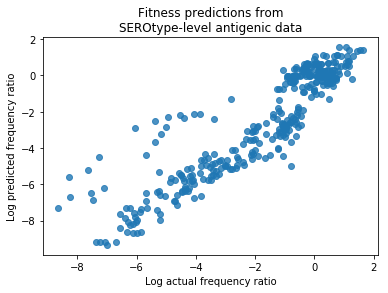

In [59]:
x = actual_frequency_ratio.values.flatten()
y = seroAntRes_predicted_frequency_ratio.values.flatten()

mask = ~np.isnan(x) & ~np.isnan(y)

sero_fit = stats.linregress(x[mask],y[mask])
print sero_fit
sns.regplot(np.log(x[mask]), np.log(y[mask]))
plt.xlabel('Log actual frequency ratio')
plt.ylabel('Log predicted frequency ratio')
plt.title('Fitness predictions from\nSEROtype-level antigenic data')
plt.show()

LinregressResult(slope=0.81766119646624946, intercept=0.060252350103293884, rvalue=0.80446412253534205, pvalue=7.3877064747981823e-82, stderr=0.032134141979786889)


/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


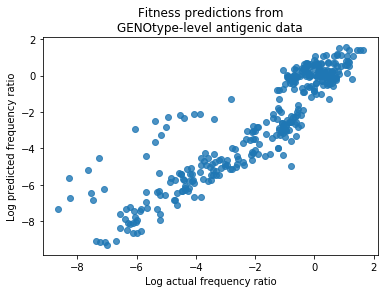

In [60]:
x = actual_frequency_ratio.values.flatten()
y = genoAntRes_predicted_frequency_ratio.values.flatten()

mask = ~np.isnan(x) & ~np.isnan(y)

geno_fit = stats.linregress(x[mask],y[mask])
print geno_fit
sns.regplot(np.log(x[mask]), np.log(y[mask]))
plt.xlabel('Log actual frequency ratio')
plt.ylabel('Log predicted frequency ratio')
plt.title('Fitness predictions from\nGENOtype-level antigenic data')
plt.show()

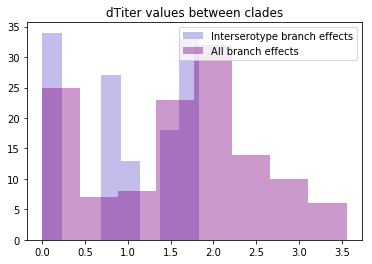

In [30]:
sns.distplot(pd.Series(interserotype_effects_dTiters.values()), 
             label='Interserotype branch effects', color='slateblue', bins=8, kde=False)
sns.distplot(pd.Series(all_branch_effects_dTiters.values()),
             label='All branch effects', color='purple', bins=8, kde=False)
plt.legend()
plt.title('dTiter values between clades')
plt.show()

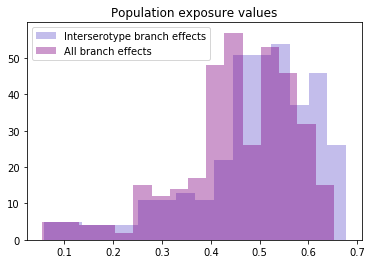

In [47]:
sns.distplot(pd.Series(sero_exposure.values.flatten()[~ np.isnan(sero_exposure.values.flatten())]), 
              label='Interserotype branch effects', color='slateblue', kde=False)
sns.distplot(pd.Series(geno_exposure.values.flatten()[~ np.isnan(geno_exposure.values.flatten())]), 
              label='All branch effects', color='purple', kde=False)
plt.legend()
plt.title('Population exposure values')
plt.show()

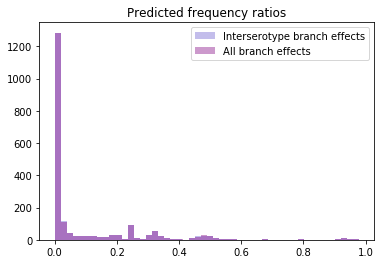

0.0909090909091
0.0909090909091


In [54]:
sns.distplot(pd.Series(seroAntRes_predicted_frequencies.values.flatten()[~ np.isnan(seroAntRes_predicted_frequencies.values.flatten())]), 
              label='Interserotype branch effects', color='slateblue', kde=False)
sns.distplot(pd.Series(genoAntRes_predicted_frequencies.values.flatten()[~ np.isnan(genoAntRes_predicted_frequencies.values.flatten())]), 
              label='All branch effects', color='purple', kde=False)
plt.legend()
plt.title('Predicted frequency ratios')
plt.show()

print seroAntRes_predicted_frequency_ratio.mean().mean()
print genoAntRes_predicted_frequency_ratio.mean().mean()

In [42]:
# def pool_analysis(population_exposure, antigenic_resolution, years_forward):
    
#     pooled_exposure = []
#     pooled_frequency_ratio = []

#     for i, df in population_exposure.items():
#         pooled_exposure += df['population_exposure'].tolist()
#         pooled_frequency_ratio += df['frequency_ratio'].tolist()

#     return {'pooled_exposure': pooled_exposure, 'pooled_frequency_ratio': pooled_frequency_ratio, 
#             'antigenic_resolution': antigenic_resolution, 'years_forward': years_forward}

# def plot_pooled_analysis(pooled, ax):
    
#     pooled_fit = stats.linregress(pooled['pooled_exposure'], pooled['pooled_frequency_ratio'])
#     print pooled_fit
    
#     sns.regplot(pd.Series(pooled['pooled_exposure']), pd.Series(pooled['pooled_frequency_ratio']), ax=ax, lowess=True)
#     ax.text(1,1, 'r = %.2f'%pooled_fit.rvalue,transform=ax.transAxes)
#     ax.set_xlabel('Population Immunity')
#     ax.set_ylabel('frequency ratio (t+%d / t)'%pooled['years_forward'])

#     ax.set_title('%s-level\nantigenic resolution'%pooled['antigenic_resolution'])

In [23]:
# pooled_geno_exposure = pool_analysis(geno_exposure, antigenic_resolution='clade', years_forward=years_forward)

# pooled_sero_exposure = pool_analysis(sero_exposure, antigenic_resolution='serotype', years_forward=years_forward)

# fig, (ax1,ax2) = plt.subplots(1,2)
# plot_pooled_analysis(pooled_geno_exposure, ax1)
# plot_pooled_analysis(pooled_sero_exposure, ax2)
# plt.tight_layout()
# plt.show()

In [26]:
# def test_year_params(years_forward, years_back, clades, antigenic_resolution):
#     ##### TIMEPOINTS PARSING #####
#     #  pivots = augur jargon for time points; used here for consistency across codebase

#     pivots_back = years_back*ppy
#     pivots_forward = years_forward*ppy

#     # pivots with enough data before to infer population exposure AND enough data after to test prediction
#     informative_pivots = pivots[pivots_back:-1*pivots_forward] 
#     informative_date_range = (informative_pivots[0], informative_pivots[-1])

#     if years_forward in precalculated_frequency_ratios:
#         frequency_ratio = precalculated_frequency_ratios[years_forward]
#     else:
#         frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies)
#         precalculated_frequency_ratios[years_forward] = frequency_ratio
        
#     population_exposure = calc_all_population_exposure(gamma=-0.125, sigma=-0.15, 
#                                                  all_clades=clades, 
#                                                  antigenic_resolution=antigenic_resolution, 
#                                                  frequencies=frequencies, frequency_ratio=frequency_ratio,
#                                                  pivots=pivots, ppy=ppy, 
#                                                  pivots_back=pivots_back,
#                                                  informative_pivots=informative_pivots, 
#                                                  max_years_back=years_back,
#                                                  informative_date_range=informative_date_range)
    
#     pooled = pool_analysis(population_exposure, 
#                                                antigenic_resolution=antigenic_resolution, 
#                                                years_forward=years_forward)
    
#     pooled_fit = stats.linregress(pooled['pooled_exposure'], pooled['pooled_frequency_ratio'])
#     return pooled_fit.rvalue

# resolutions = ['clade', 'serotype']
# clades = [genotype_clades, serotype_clades]

# clade_frequency_predictions = []

# time_frames = [1,3,5,8,10]

# for res in resolutions:
#     for cl in clades:
#         for yrs_fwd in time_frames:
#             for yrs_back in time_frames:
#                 log = {'antigenic_resolution': res, 
#                       'genetic_resolution': len(cl),
#                       'years_forward': yrs_fwd,
#                       'years_back': yrs_back,
#                       'rvalue': test_year_params(yrs_fwd, yrs_back, cl, res)}
#                 clade_frequency_predictions.append(log)

In [91]:
# ####    PLOT   #####
# antigenic_clade_exposure = geno_exposure
# def plot_exposure_delta_frequencies(i, ax, population_exposure):
#     sns.regplot('population_exposure', 'frequency_ratio', data=population_exposure[i], ax=ax)
#     ax.set_title(i)
#     ax.set_xlabel('Population immunity')
#     ax.set_ylabel('%d-yr change in frequency'%years_forward)

# sns.set(style='whitegrid', font_scale=1.1, palette='pastel')
# n_j_vals = len(antigenic_clade_exposure.keys())
# ncols = 4
# nrows = int(ceil(n_j_vals/ncols))

# sns.set_style('whitegrid')
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)
# for j, ax in zip(sorted(antigenic_clade_exposure.keys()), axes.flatten()):
#     plot_exposure_delta_frequencies(j, ax, antigenic_clade_exposure)
# plt.tight_layout()
# plt.show()

In [ ]:
# def predict_all_trajectories((gamma, sigma)):
#     pooled_exposure = []
#     pooled_delta_f = []

#     informative_clades = [c for c in antigenic_clades if frequencies[c].max() >= 0.1]
#     for i in informative_clades:
#         pooled_exposure += calc_population_exposure(i, gamma, sigma, antigenic_clades)
#         pooled_delta_f += delta_frequencies[i].tolist()

#     slope, intercept, r_value, p_value, std_err =  stats.linregress(pooled_exposure, pooled_delta_f)
#     return -1.*r_value


# optimized_parameters = optimize.minimize(fun=predict_all_trajectories, x0=[-0.125, -0.15],
#                                          bounds=[(-1.0, -0.1), (-0.2, -0.02)],tol=1e-3,options={'maxiter': 150})

# print optimized_parameters

In [ ]:
# def predict_all_trajectories(sigma):
#     pooled_exposure = []
#     pooled_delta_f = []

#     informative_clades = [c for c in antigenic_clades if frequencies[c].max() >= 0.1]
#     for i in informative_clades:
#         pooled_exposure += calc_population_exposure(i, -0.125, sigma, antigenic_clades)
#         pooled_delta_f += delta_frequencies[i].tolist()

#     slope, intercept, r_value, p_value, std_err =  stats.linregress(pooled_exposure, pooled_delta_f)
#     return -1.*r_value


# optimized_parameters = optimize.minimize(fun=predict_all_trajectories, x0=[-0.15],
#                                          bounds=[(-1.0, -0.01)],tol=1e-3,
#                                          options={'maxiter': 150})

# print optimized_parameters

In [67]:
def predict_frequencies(population_exposure, frequencies, years_forward):
    ''' 
    input: population_exposure is a pd.DataFrame(columns=clades, index=pivots, 
                                                values= proportion of the population protected from i)
           frequencies is a pd.DataFrame(columns=clades, index=pivots,
                                         values = relative frequency of clade i at each time point)
    
    output: pd.DataFrame(columns=clades, index=pivots, values=predicted frequency of clade i at each pivot)
    '''
    
    f = 1. - population_exposure # fitness = 1. - proportion of the population protected
    shared_columns = f.columns.values # clades that we've calculated fitness for
    initial_frequencies = frequencies[shared_columns]
    predicted_delta_frequencies = f.applymap(lambda x: np.log(x+years_forward)) # df = e^(Pi + dt), applied element-wise
    raw_predicted_frequencies = initial_frequencies.add(predicted_delta_frequencies, fill_value=0.) # f = f0 + df
    sum_predicted_frequencies = raw_predicted_frequencies.sum(axis=1) # sum of all predicted frequencies at each time point
    
    predicted_frequencies = raw_predicted_frequencies.divide(sum_predicted_frequencies, axis='index') # norm each row to sum to 1
    return predicted_frequencies

In [69]:
from random import random
demo_pop_exposure = pd.DataFrame([[0.3,0.6],
                                 [0.4,0.5],
                                 [0.5,0.4]], 
                                 index=[1980., 1981., 1982.], 
                                 columns=['clade A', 'clade B'])
demo_frequencies = pd.DataFrame([[0.5,0.5],
                                [0.6,0.4],
                                [0.7,0.3]], 
                               index=[1980., 1981., 1982.],
                               columns=['clade A', 'clade B'])

print predict_frequencies(demo_pop_exposure, demo_frequencies, 1)

demo_pop_exposure = demo_pop_exposure.applymap(lambda x: x + random())
print predict_frequencies(demo_pop_exposure, demo_frequencies, 1)

         clade A   clade B
1980.0  0.551994  0.448006
1981.0  0.570526  0.429474
1982.0  0.589434  0.410566
         clade A   clade B
1980.0  0.675415  0.324585
1981.0  0.873705  0.126295
1982.0  0.611258  0.388742
